In [1]:
# NOTE: Text preprocessing (lowercase/URLs/punct/stopwords/lemma).
# Colab: install required packages
!pip -q install textblob wordcloud emoji tqdm nltk

# NLTK data (for stopwords + lemmatizer)
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 7.7 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [2]:
import os
OUTPUT_DIR = "/content/ai_cloud_devops_tweets"  # or "/content/drive/MyDrive/ai_cloud_devops_tweets"
os.makedirs(OUTPUT_DIR, exist_ok=True)

TOPIC = "AI in Cloud Computing and DevOps"
N_TWEETS = 10_000
RANDOM_SEED = 123


In [3]:
# NOTE: Data analysis setup (Pandas import).
import random, uuid
from datetime import datetime, timedelta
import pandas as pd
import numpy as np

random.seed(RANDOM_SEED); np.random.seed(RANDOM_SEED)

providers = ["AWS", "Azure", "GCP", "OCI", "DigitalOcean"]
areas = ["AIOps","MLOps","LLMOps","DevOps","Platform Engineering","SRE","FinOps","Cloud Security","Observability","Kubernetes"]
trends = [
    "predictive autoscaling","anomaly detection","log summarization","root-cause analysis",
    "auto-remediation playbooks","cost forecasting","policy-as-code validation","test generation",
    "IaC code review","runbook generation","capacity planning","drift detection",
    "genAI chat for on-call","incident timeline summaries","performance regression alerts",
    "secret scanning","image signing","supply chain security","blue/green orchestration hints"
]
tools = ["Prometheus","Grafana","OpenTelemetry","Kubernetes","ArgoCD","Tekton","Terraform","Pulumi",
         "Ansible","Cosign","Syft","Falco","Jenkins","GitHub Actions","GitLab CI","KEDA","Istio","Linkerd"]
emojis = ["🚀","🤖","⚙️","📈","🧠","🔒","🛠️","🌩️","🧪","🧰","📊","💡","🔥","✅","🔍"]
hashtags = ["#AI","#AIOps","#MLOps","#LLMOps","#DevOps","#Cloud","#Kubernetes","#SRE",
            "#FinOps","#Observability","#Security","#Automation","#InfraAsCode","#GenAI","#PlatformEngineering"]
mentions = ["@cloud_ninja","@ops_girl","@sre_guy","@ml_builder","@devops_daily","@platform_team"]
urls = ["https://bit.ly/aiops","https://example.com/blog/ai-devops","https://docs.example/guide","https://short.ly/llmops","https://t.co/abcd1"]

templates = [
    "Today I tried {trend} with {tool} on {provider}. Huge boost for {area}! {emoji} {tags}",
    "GenAI for {trend} in {area} is getting real. {provider} notes coming soon. {emoji} {tags} {url}",
    "We wired {tool} + LLM to auto-suggest runbooks. {trend} saved our on-call last night. {emoji} {tags}",
    "Hot take: AI won’t replace {area}, it upgrades it. {trend} + {tool} on {provider}. {emoji} {tags}",
    "Built a POC: {trend} using {tool} metrics. Shipping to prod on {provider} next week. {emoji} {tags} {url}",
    "If you’re still ignoring {trend} in {area}, you’re missing low-hanging fruit. {emoji} {tags}",
    "We added {trend} checks to CI with {tool}. Fewer rollbacks already. {emoji} {tags}",
    "Pairing LLMs with {tool} for {trend}. Write once, scale everywhere on {provider}. {emoji} {tags}",
    "Reality check: {trend} isn’t magic, but paired with {tool} it’s a force multiplier. {emoji} {tags}",
    "Tuning prompts for {trend} in {area}. Observability data + LLM is wild. {emoji} {tags} {url}",
    "S/O to {mention} for sharing how {provider} teams do {trend} with {tool}. Bookmarked. {emoji} {tags}",
    "From toil to leverage: {trend} via {tool}. Our {area} KPIs look better already. {emoji} {tags}",
    "Demoed {trend} on {provider}. {tool} signals → LLM advice → safer deploys. {emoji} {tags} {url}",
    "AI copilots for IaC are underrated. {trend} caught drift before prod. {emoji} {tags}",
    "Incident drill: {trend} used {tool} traces to suggest actions. Reduced MTTR. {emoji} {tags}"
]

def rand_time(days=90):
    now = datetime.now()
    delta = timedelta(days=random.randint(0,days), hours=random.randint(0,23), minutes=random.randint(0,59))
    return (now - delta).strftime("%Y-%m-%d %H:%M:%S")

def tag_str():
    return " ".join(random.sample(hashtags, k=random.randint(2,4)))

def user_handle():
    roots = ["cloud","dev","ops","ml","ai","platform","sre","finops"]
    return f"{random.choice(roots)}_{random.randint(1000,9999)}"

def make_text():
    t = random.choice(templates).format(
        trend=random.choice(trends),
        tool=random.choice(tools),
        provider=random.choice(providers),
        area=random.choice(areas),
        emoji=random.choice(emojis),
        tags=tag_str(),
        url=random.choice(urls),
        mention=random.choice(mentions)
    )
    if random.random() < 0.25: t += f" {random.choice(mentions)}"
    if random.random() < 0.25: t += f" {random.choice(urls)}"
    if random.random() < 0.15: t += " !!!"
    return t

rows = [{
    "id": str(uuid.uuid4()),
    "created_at": rand_time(90),
    "user": user_handle(),
    "text": make_text()
} for _ in range(N_TWEETS)]

df_raw = pd.DataFrame(rows)

raw_csv = os.path.join(OUTPUT_DIR, "tweets_raw.csv")
df_raw.to_csv(raw_csv, index=False)
raw_csv


'/content/ai_cloud_devops_tweets/tweets_raw.csv'

In [4]:
# NOTE: Load dataset into DataFrame.
import re, string, math, unicodedata
from collections import Counter
from tqdm import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
from wordcloud import WordCloud
from textblob import TextBlob
from emoji import replace_emoji

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

df = pd.read_csv(raw_csv)

# --- Data type conversion
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')

# --- Handle missing values
df['is_text_missing'] = df['text'].isna()
df['text'] = df['text'].fillna("")

# --- Remove duplicate rows (id + text)
df = df.drop_duplicates(subset=['id','text']).reset_index(drop=True)

# -----------------------
# Cleaning utilities
# -----------------------
URL_RE      = re.compile(r'https?://\S+')
MENTION_RE  = re.compile(r'@\w+')
HASHTAG_RE  = re.compile(r'#\w+')

# Emoji/non-ASCII handling via emoji + normalization
def remove_emojis_and_nonascii(s: str) -> str:
    s = replace_emoji(s, replace=" ")
    s = unicodedata.normalize("NFKD", s).encode("ascii", "ignore").decode("ascii")
    return s

STOPWORDS = set(stopwords.words('english'))
PUNCT_TABLE = str.maketrans("", "", string.punctuation)
LEMMATIZER = WordNetLemmatizer()

# Lightweight custom replacements (extend as needed)
CUSTOM_MAP = {
    "k8s": "kubernetes",
    "IaC": "infrastructure as code",
    "LLM": "large language model",
    "LLMs": "large language models",
}

# Tiny profanity/noise list (mask in output)
PROFANITY = {"damn", "hell", "crap"}

def mask_profanity(word: str) -> str:
    return word[0] + "*"*(len(word)-2) + word[-1] if len(word) > 2 else word

def lowercase(s): return s.lower()
def remove_urls(s): return URL_RE.sub(" ", s)
def remove_mentions(s): return MENTION_RE.sub(" ", s)
def remove_punctuation(s): return s.translate(PUNCT_TABLE)
def normalize_ws(s): return re.sub(r"\s+", " ", s).strip()

def custom_replacements(s):
    return " ".join(CUSTOM_MAP.get(w, w) for w in s.split())

def remove_stopwords(s):
    return " ".join(w for w in s.split() if w not in STOPWORDS)

def lemmatize_text(s):
    out = []
    for w in s.split():
        # simple heuristic: verb-ish endings → verb lemma; else noun lemma
        if w.endswith(("ing","ed")) and len(w) > 4:
            out.append(LEMMATIZER.lemmatize(w, pos='v'))
        else:
            out.append(LEMMATIZER.lemmatize(w))
    return " ".join(out)

ENABLE_SPELL_CORRECTION = False  # Turn on for small datasets; 10k can be slow.

def spell_correct(s):
    if not ENABLE_SPELL_CORRECTION or not s:
        return s
    try:
        if len(s) > 200:  # limit for speed
            s = s[:200]
        return str(TextBlob(s).correct())
    except Exception:
        return s

def profanity_filter(s):
    return " ".join(mask_profanity(w) if w in PROFANITY else w for w in s.split())

def clean_pipeline(s: str) -> str:
    t = lowercase(s)
    t = remove_urls(t)
    t = remove_mentions(t)
    t = remove_punctuation(t)
    t = remove_emojis_and_nonascii(t)
    t = custom_replacements(t)
    t = normalize_ws(t)
    t = remove_stopwords(t)
    t = lemmatize_text(t)
    t = profanity_filter(t)
    t = normalize_ws(t)
    t = spell_correct(t)  # optional
    t = normalize_ws(t)
    return t

# Keep raw; make clean
df["text_raw"] = df["text"].astype(str)
df["text_clean"] = df["text_raw"].progress_apply(clean_pipeline)

# -----------------------
# Feature extraction
# -----------------------
def count_hashtags(s): return len(HASHTAG_RE.findall(s))
def count_mentions(s): return len(MENTION_RE.findall(s))
def count_urls(s): return len(URL_RE.findall(s))
def word_count(s): return len(s.split()) if s else 0
def char_count(s): return len(s)

df["hashtags"]   = df["text_raw"].apply(count_hashtags)
df["mentions"]   = df["text_raw"].apply(count_mentions)
df["urls"]       = df["text_raw"].apply(count_urls)
df["word_count"] = df["text_clean"].apply(word_count)
df["char_count"] = df["text_clean"].apply(char_count)

# -----------------------
# Sentiment (TextBlob polarity)
# -----------------------
def polarity(s):
    try:
        return float(TextBlob(s).sentiment.polarity)
    except Exception:
        return 0.0

df["sentiment"] = df["text_clean"].apply(polarity)

# -----------------------
# Save cleaned outputs
# -----------------------
clean_csv = os.path.join(OUTPUT_DIR, "tweets_clean.csv")
df[["id","created_at","user","text_raw","text_clean",
    "hashtags","mentions","urls","word_count","char_count","sentiment","is_text_missing"]].to_csv(clean_csv, index=False)

# Human-readable text file (one tweet per line)
txt_path = os.path.join(OUTPUT_DIR, "tweets_clean.txt")
with open(txt_path, "w", encoding="utf-8") as f:
    for row in df["text_clean"]:
        f.write(row + "\n")

clean_csv, txt_path


100%|██████████| 10000/10000 [00:08<00:00, 1151.76it/s]


('/content/ai_cloud_devops_tweets/tweets_clean.csv',
 '/content/ai_cloud_devops_tweets/tweets_clean.txt')

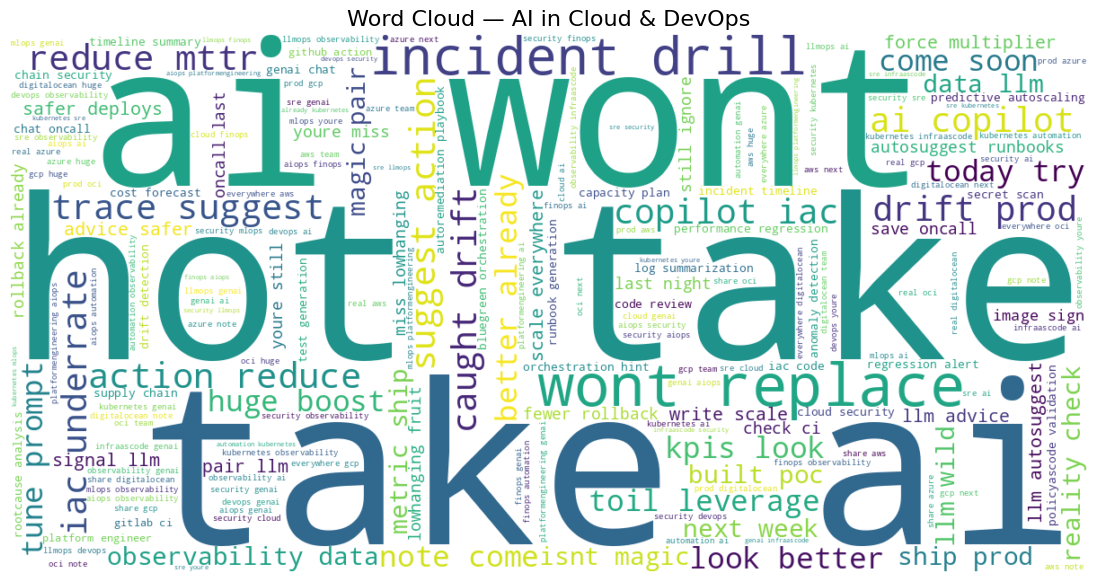

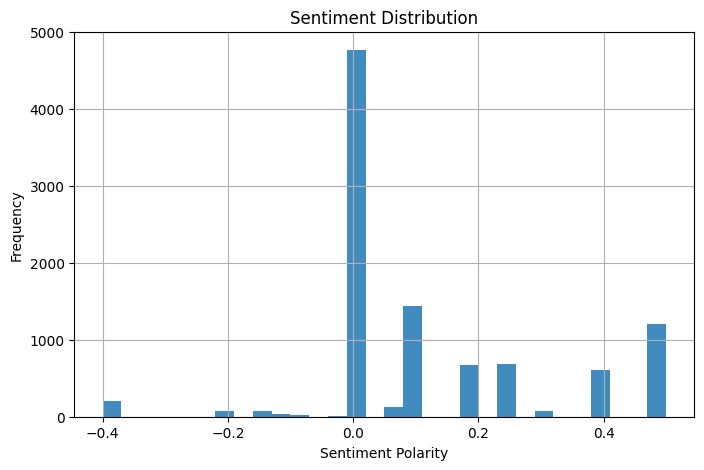

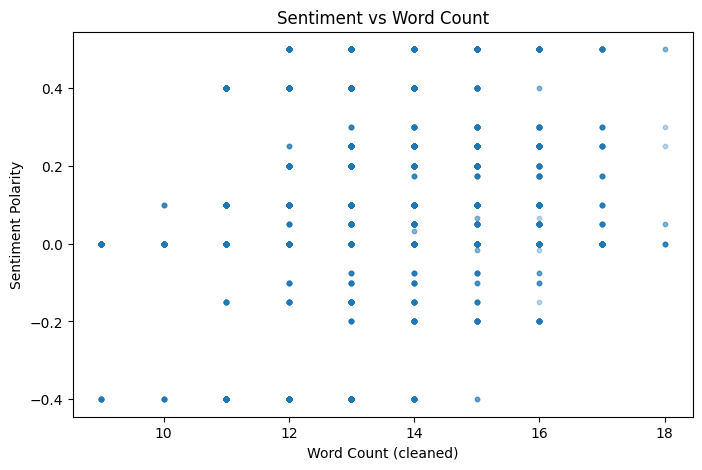

('/content/ai_cloud_devops_tweets/wordcloud.png',
 '/content/ai_cloud_devops_tweets/sentiment_hist.png',
 '/content/ai_cloud_devops_tweets/sentiment_scatter.png')

In [5]:
# NOTE: Visualization block.
import matplotlib.pyplot as plt
from collections import Counter

# Word Cloud (on cleaned text)
all_text = " ".join(df["text_clean"].tolist())
wc = WordCloud(width=1200, height=600, background_color="white").generate(all_text)

plt.figure(figsize=(14,7))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud — AI in Cloud & DevOps", fontsize=16)
wc_path = os.path.join(OUTPUT_DIR, "wordcloud.png")
plt.savefig(wc_path, bbox_inches="tight")
plt.show()

# Sentiment histogram
plt.figure(figsize=(8,5))
df["sentiment"].hist(bins=30, alpha=0.85)
plt.xlabel("Sentiment Polarity")
plt.ylabel("Frequency")
plt.title("Sentiment Distribution")
hist_path = os.path.join(OUTPUT_DIR, "sentiment_hist.png")
plt.savefig(hist_path, bbox_inches="tight")
plt.show()

# Sentiment vs word count scatter
plt.figure(figsize=(8,5))
plt.scatter(df["word_count"], df["sentiment"], alpha=0.3, s=10)
plt.xlabel("Word Count (cleaned)")
plt.ylabel("Sentiment Polarity")
plt.title("Sentiment vs Word Count")
scatter_path = os.path.join(OUTPUT_DIR, "sentiment_scatter.png")
plt.savefig(scatter_path, bbox_inches="tight")
plt.show()

wc_path, hist_path, scatter_path


In [6]:
# Peek a few rows
df.head(3)


,id,created_at,user,text,is_text_missing,text_raw,text_clean,hashtags,mentions,urls,word_count,char_count,sentiment
0,667d116d-bf53-48fd-9b49-a81209696450,2025-08-14 13:40:48,sre_5367,GenAI for anomaly detection in Observability i...,False,GenAI for anomaly detection in Observability i...,genai anomaly detection observability get real...,3,0,1,13,89,0.2
1,0d66fcb9-5737-4faa-aea6-40ec9804732f,2025-06-26 18:49:48,sre_2144,Today I tried capacity planning with GitLab CI...,False,Today I tried capacity planning with GitLab CI...,today try capacity plan gitlab ci aws huge boo...,4,0,0,14,95,0.4
2,2d54258b-04df-4aa6-b378-e84942dc21de,2025-07-12 11:12:48,finops_4389,AI copilots for IaC are underrated. image sign...,False,AI copilots for IaC are underrated. image sign...,ai copilot iac underrate image sign caught dri...,4,0,0,13,100,0.0


In [7]:
# NOTE: Quick frequency analysis of tokens.
# Frequency table: top tokens (quick view)
from collections import Counter
tokens = " ".join(df["text_clean"]).split()
freq = Counter(tokens)
freq.most_common(20)


[('ai', 3420),
 ('genai', 3274),
 ('observability', 3059),
 ('security', 2915),
 ('kubernetes', 2894),
 ('llm', 2607),
 ('cloud', 2434),
 ('finops', 2426),
 ('sre', 2417),
 ('llmops', 2402),
 ('mlops', 2392),
 ('devops', 2367),
 ('aiops', 2355),
 ('platformengineering', 2074),
 ('automation', 2026),
 ('infraascode', 1993),
 ('prod', 1346),
 ('pair', 1316),
 ('already', 1310),
 ('check', 1290)]

In [8]:
# Basic stats
df[["word_count","char_count","sentiment"]].describe()


,word_count,char_count,sentiment
count,10000.000000,10000.000000,10000.000000
mean,13.363700,95.792100,0.120462
std,1.590558,14.118598,0.195401
min,9.000000,50.000000,-0.400000
25%,12.000000,86.000000,0.000000
50%,13.000000,95.000000,0.000000
75%,14.000000,105.000000,0.250000
max,18.000000,148.000000,0.500000
